In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=1f678ab4a4413dba71e9fc5cb8db01846abd4a48a47dee7f8d27326853533b04
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [280]:
# Importing necessary libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno

In [304]:
# Create a Spark session
ACCESS_KEY = "replace_with_your_aws_access_key"
SECRET_KEY = "replace_with_your_aws_secret_key"

spark = SparkSession.builder \
    .appName("big_data_project") \
    .config("spark.hadoop.fs.s3a.access.key", ACCESS_KEY)\
    .config("spark.hadoop.fs.s3a.secret.key", SECRET_KEY)\
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")\
    .getOrCreate()
spark.conf.set("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
# spark = SparkSession.builder.appName("big_data_project").getOrCreate()

In [305]:
# Read the CSV file from S3 into a DataFrame
spark

# 1. Load Data:
##### Load your dataset into a Spark DataFrame.

In [306]:
# Load your dataset from S3
df = spark.read.csv("s3://water-quality-datasets/water_potability.csv", header=True, inferSchema=True)

# New Section

# 2. Basic Data Exploration:
##### Perform initial checks to understand your data.

In [307]:
# Display the schema (column names and data types)
df.printSchema()

# Display the first few rows
df.show(5)

# Get summary statistics
df.describe().show()
#Get the number of rows
print(f'There are total {df.count()} row, Let print first 2 data rows:')

print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

root
 |-- ph: double (nullable = true)
 |-- Hardness: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Sulfate: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Trihalomethanes: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: integer (nullable = true)

+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|               ph|          Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|
+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|             null| 204.890455471

,Column Name,Data type
0,ph,double
1,Hardness,double
2,Solids,double
3,Chloramines,double
4,Sulfate,double
5,Conductivity,double
6,Organic_carbon,double
7,Trihalomethanes,double
8,Turbidity,double
9,Potability,int


# 3. Data Cleaning and Preprocessing:
##### Apply necessary data cleaning steps using Spark's DataFrame transformations..

In [308]:
# Count missing values in each column
missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_counts.show()
plt.show()

+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
| ph|Hardness|Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
|491|       0|     0|          0|    781|           0|             0|            162|        0|         0|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+



In [309]:
# Handling Missing Values
# Replace missing values in numeric columns with mean value
numeric_columns = ['ph', 'Sulfate', 'Trihalomethanes']
for column in numeric_columns:
    mean_value = df.select(column).agg({"*": "avg"}).collect()[0][0]
    df = df.withColumn(column, when(col(column).isNull(), mean_value).otherwise(col(column)))

# Show the cleaned DataFrame
df.show()

+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+
|                ph|          Hardness|            Solids|       Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|
+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+
| 7.080794504276819| 204.8904554713363|20791.318980747026| 7.300211873184757|368.51644134980336| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|
|  3.71608007538699|129.42292051494425|18630.057857970347|    6.635245883862| 333.7757766108134| 592.8853591348523|15.180013116357259| 56.32907628451764| 4.500656274942408|         0|
| 8.099124189298397|224.23625939355776|19909.541732292393| 9.275883602694089| 33

In [310]:
# check if there are any missing values
missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_counts.show()
#Get the number of rows
print(f'There are total {df.count()} row, Let print first 2 data rows:')

+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
| ph|Hardness|Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
|  0|       0|     0|          0|      0|           0|             0|              0|        0|         0|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+

There are total 3276 row, Let print first 2 data rows:


In [311]:
# Removing Duplicates
df.show()

+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+
|                ph|          Hardness|            Solids|       Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|
+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+
| 7.080794504276819| 204.8904554713363|20791.318980747026| 7.300211873184757|368.51644134980336| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|
|  3.71608007538699|129.42292051494425|18630.057857970347|    6.635245883862| 333.7757766108134| 592.8853591348523|15.180013116357259| 56.32907628451764| 4.500656274942408|         0|
| 8.099124189298397|224.23625939355776|19909.541732292393| 9.275883602694089| 33

In [312]:
df.select('Potability').describe().show()

+-------+-------------------+
|summary|         Potability|
+-------+-------------------+
|  count|               3276|
|   mean| 0.3901098901098901|
| stddev|0.48784916967025477|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



# 4. Data Visualization:
##### plotting the data to get more insights

THEME


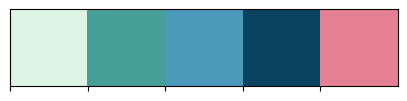

In [313]:
#theme
theme = ["#DEF5E5", "#459E97", "#4B9ABB","#0A4361","#E68193",]
print('THEME')
sns.palplot(sns.color_palette(theme))

In [314]:
# Convert a PySpark DataFrame (df) to a Pandas DataFrame (pandas_df)
pandas_df = df.toPandas()
pandas_df = pandas_df.astype(float)
pandas_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0.0
1,3.716080,129.422921,18630.057858,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0.0
2,8.099124,224.236259,19909.541732,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0.0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0.0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0.0


In [315]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3276 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          3276 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3276 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   float64
dtypes: float64(10)
memory usage: 256.1 KB


In [316]:
# Create the dataframe that contains the counts of different values in the 'Potability' column of 'pandas_df'
d = pd.DataFrame(pandas_df["Potability"].value_counts())

# Create a pie chart using Plotly Express ('px')
fig = px.pie(
    d,  # Data for the chart
    values="Potability",  # Column to be used as values for the pie chart
    names=["Not Potable", "Potable"],  # Labels for the pie chart sections
    hole=0.35,  # Size of the center hole in the pie chart
    opacity=0.8,  # Opacity of the chart elements
    labels={"label": "Potability", "Potability": "Number of Samples"},  # Custom labels for the chart
)

# Update the layout of the chart
fig.update_layout(
    title=dict(text="Pie Chart of Potability Feature"),
    width=800,  # Set the width of the figure (adjust as needed)
    height=400,  # Set the height of the figure (adjust as needed)
)

# Update the style of the chart traces
fig.update_traces(
    textposition="outside",  # Position of the text labels (outside the pie slices)
    textinfo="percent+label",  # Information displayed on the text labels
)

# Display the pie chart
fig.show()

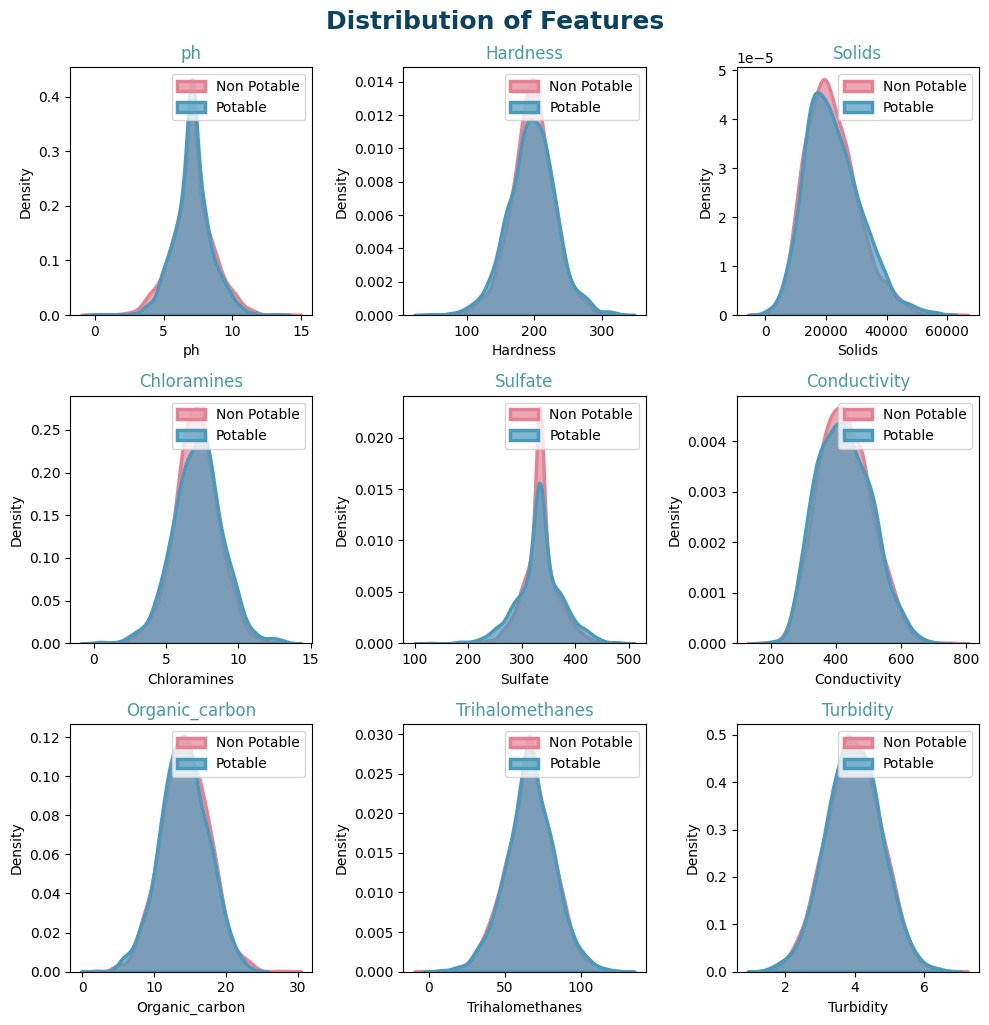

In [317]:
# Filter rows where 'Potability' column is 0 (non-potable samples)
non_potable = pandas_df.query("Potability == 0")

# Filter rows where 'Potability' column is 1 (potable samples)
potable = pandas_df.query("Potability == 1")

# Create a figure for the subplots with a smaller size
plt.figure(figsize=(10, 10))  # Adjust the size as needed

# Iterate through the columns of the DataFrame
for ax, col in enumerate(pandas_df.columns[:9]):
    plt.subplot(3, 3, ax + 1)  # Create a subplot
    plt.title(col, color=theme[1])  # Set the title of the subplot with theme color

    # Create KDE plots for both classes, customizing colors and appearance
    sns.kdeplot(x=non_potable[col], label="Non Potable", fill=True, common_norm=False, color=theme[4], alpha=0.7, linewidth=2.5)
    sns.kdeplot(x=potable[col], label="Potable", fill=True, common_norm=False, color=theme[2], alpha=0.7, linewidth=2.5)

    plt.legend()  # Show the legend

plt.tight_layout()

# Create a main title with adjusted font size and theme color
plt.suptitle('Distribution of Features', y=1.02, size=18, color=theme[3], weight='bold')

# Display the subplots
plt.show()

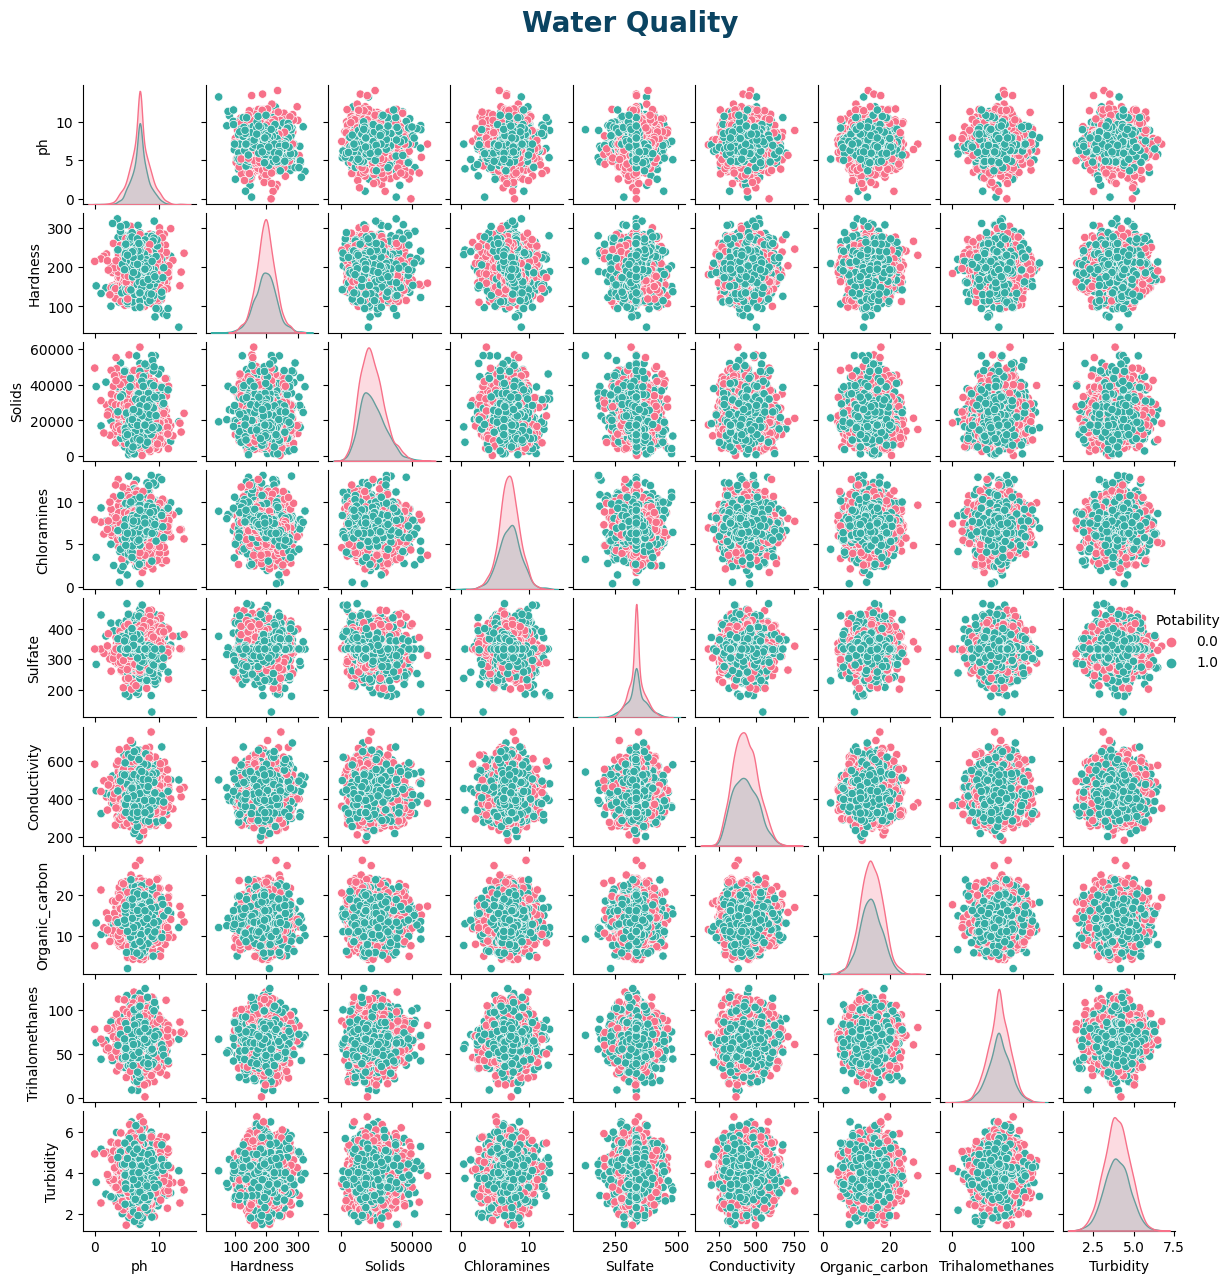

In [318]:
# Create a pairplot
ax = sns.pairplot(
    pandas_df,
    hue="Potability",           # Differentiate by color based on the "Potability" column
    diag_kind="kde",            # Use KDE plots on the diagonal
    kind="scatter",             # Use scatter plots for off-diagonal plots
    palette="husl"              # Set color palette
)

# Set the figure size for the pairplot
ax.fig.set_size_inches(12, 12)  # Adjust the size as needed

# Set the main title for the pairplot
ax.fig.suptitle('Water Quality', y=1.05, size=20, color=theme[3], weight='bold')

# Display the pairplot
plt.show()

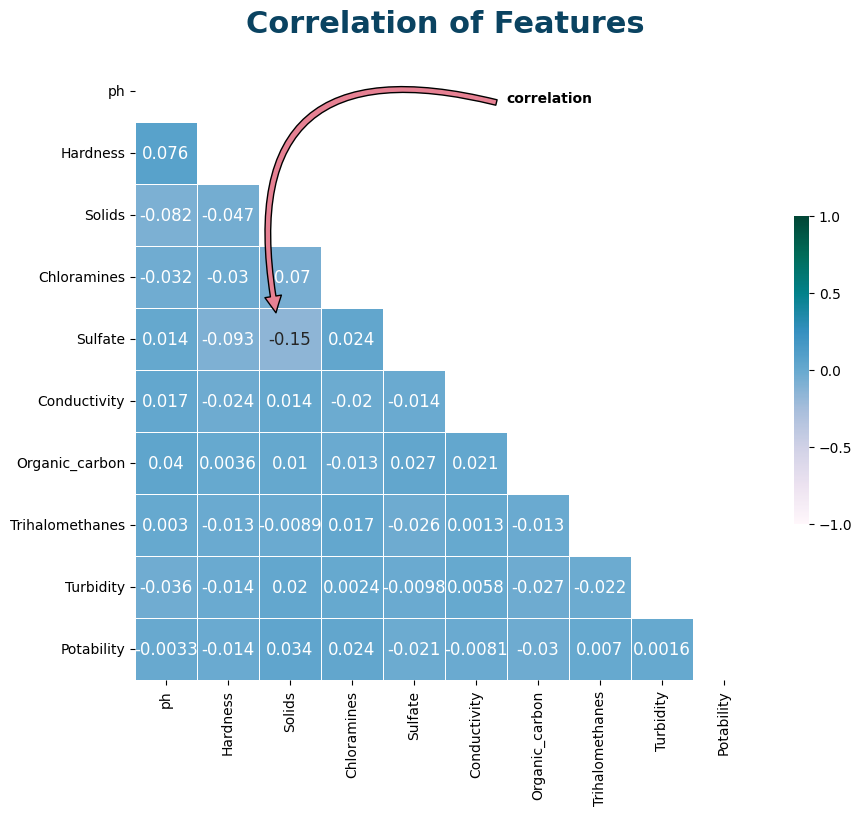

In [319]:
# Create a mask for the upper triangle of the correlation matrix
mask = np.zeros_like(pandas_df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Create a figure and axis with a larger size
fig, ax = plt.subplots(figsize=(10, 10))

# Create a heatmap of the correlation matrix
heatmap = sns.heatmap(
    pandas_df.corr(),
    mask=mask,
    square=True,
    linewidths=0.5,
    cmap='PuBuGn',
    cbar_kws={'shrink': 0.4, "ticks": [-1, -0.5, 0, 0.5, 1]},
    vmin=-1,
    vmax=1,
    annot=True,
    annot_kws={"size": 12}
)

# Customize the tick labels
ax.set_yticklabels(pandas_df.corr(), rotation=0)
ax.set_xticklabels(pandas_df.corr())

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

# Annotate the plot
ax.annotate(
    'correlation',
    fontsize=10,
    fontweight='bold',
    xy=(2.3, 4.2),
    xycoords='data',
    xytext=(0.6, 0.95),
    textcoords='axes fraction',
    arrowprops=dict(
        facecolor=theme[4],
        shrink=0.025,
        connectionstyle='arc3, rad=0.80'
    ),
    horizontalalignment='left',
    verticalalignment='top'
)

# Set the title of the plot
ax.set_title('Correlation of Features', size=22, color=theme[3], weight='bold', pad=20)

plt.show()

## PREPARING THE DATA FOR MODELLING

In [327]:
# Import statement for splitting data into training and testing sets
from sklearn.model_selection import train_test_split

# Import statements for various scoring metrics
from sklearn.metrics import precision_score, accuracy_score, mean_absolute_error, mean_squared_error

# Import statements for different classifier models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Import statement for XGBoost classifier
from xgboost import XGBClassifier

#Hyper-Parameter-Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [328]:
print('The water-potability file has')
print('   Rows      Columns')
print('   {}         {}\n' .format(pandas_df.shape[0], pandas_df.shape[1]))

print(pandas_df.info())

The water-potability file has
   Rows      Columns
   3276         10

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3276 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          3276 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3276 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   float64
dtypes: float64(10)
memory usage: 256.1 KB
None


In [329]:
X = pandas_df.drop("Potability", axis = 1).values
y = pandas_df["Potability"].values

In [330]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print("X_train",X_train.shape)
print("X_test",X_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

X_train (2620, 9)
X_test (656, 9)
y_train (2620,)
y_test (656,)


In [331]:
#finding the best models with base parameters
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Ridge', RidgeClassifier()),
    ('SGD Classifier', SGDClassifier(max_iter=1000, tol=1e-3)),
    ('Support Vector Classifier', SVC()),
    ('NuSVC', NuSVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Gaussian NB', GaussianNB()),
    ('Bernoulli NB', BernoulliNB()),
    ('Perc', Perceptron()),
    ('Nearest Centroid', NearestCentroid()),
    ('Random Forest Classifier', RandomForestClassifier()),
    ('Ada Boost Classifier', AdaBoostClassifier()),
    ('XGB Classifier', XGBClassifier(verbosity = 0)),
    ('Passive Aggressive', PassiveAggressiveClassifier())
]

results = dict()
for name, model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)


    score = accuracy_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    precision = precision_score(y_test, pred)
    results[name] = score

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/

In [332]:
#storing the results into dataframe
df_results = pd.DataFrame([results])
df_results = df_results.transpose()
df_results = df_results.rename(columns={0:'Score'}).sort_values(by='Score',ascending=False)

In [333]:
df_results.style.set_properties(**{'background-color': theme[1],
                                    'color': 'black',
                                    'border': '1px  solid black'})

,Score
Random Forest Classifier,0.670732
XGB Classifier,0.663110
Gaussian NB,0.631098
Logistic Regression,0.628049
Ridge,0.628049
SGD Classifier,0.628049
Support Vector Classifier,0.628049
Bernoulli NB,0.628049
Perc,0.628049
Ada Boost Classifier,0.620427


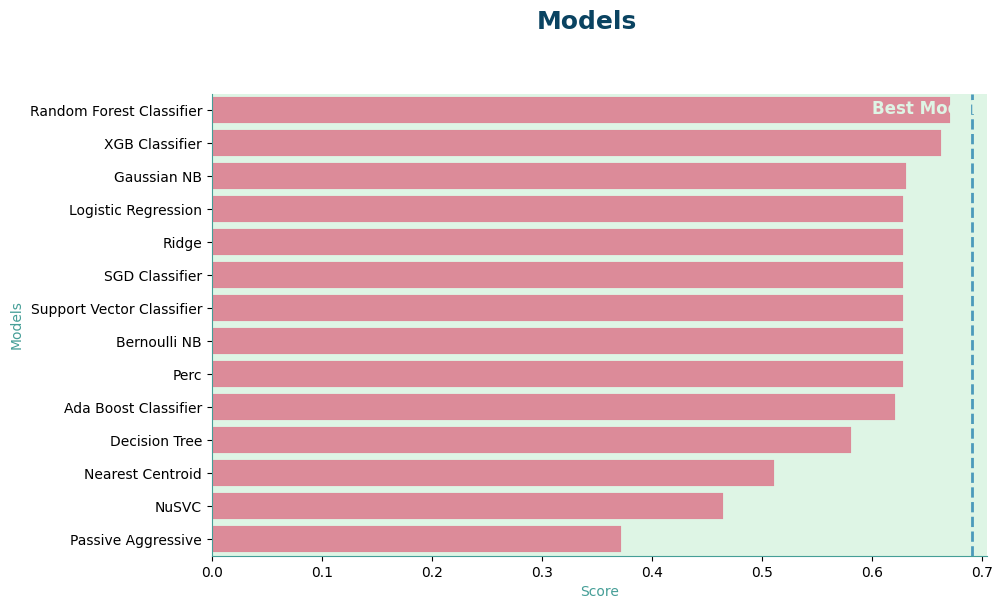

In [334]:
# Create a figure with adjusted size
fig = plt.figure(figsize=(10, 6))  # Adjust the size as needed

# Create a barplot using Seaborn with theme colors
ax = sns.barplot(data=df_results,
                 y=df_results.index,
                 x='Score',
                 color=theme[4],
                 saturation=0.8,
                 edgecolor=theme[4],
                 linewidth=0.1)

# Set the main title for the plot with theme color
ax.figure.suptitle('Models', y=1.02, size=18, color=theme[3], weight='bold')

# Add text indicating the best model with theme color
ax.text(x=0.6, y=0.12, s='Best Model', fontsize=12, weight='bold', color=theme[0])

# Set labels for the x and y axes with theme colors
plt.xlabel('Score', color=theme[1])
plt.ylabel('Models', color=theme[1])

# Add a vertical line at a specific x-coordinate with theme color
plt.axvline(x=0.691, ymin=0, ymax=1,
            linewidth=2, linestyle="--",
            color=theme[2])

# Set background color using theme color
ax.set_facecolor(theme[0])

# Hide the spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color(theme[1])
ax.spines['bottom'].set_color(theme[1])

# Display the plot
plt.show()

### Hyper Parameter Tuning

In [335]:
randomf_grid = {"n_estimators": np.arange(10,1000,50),
           "max_depth": [None, 3, 5, 7, 10],
           "min_samples_split": np.arange(2,20,2),
           "min_samples_leaf": np.arange(1, 25, 1)}

In [336]:
# Create a RandomizedSearchCV instance for RandomForestClassifier
Rand_search_rf = RandomizedSearchCV(
    RandomForestClassifier(),              # Base classifier
    param_distributions=randomf_grid,      # Parameter distributions for random search
    cv=5,                                  # Number of cross-validation folds
    n_iter=20,                             # Number of parameter settings to sample
    verbose=True,                          # Print progress messages
    n_jobs=-1                              # Number of CPU cores to use (-1 for all available cores)
)

# Fit the RandomizedSearchCV instance to the training data
Rand_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 5, 7, 10],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [337]:
# Access the best parameters found by the RandomizedSearchCV
best_params = Rand_search_rf.best_params_

{'n_estimators': 110,
 'min_samples_split': 18,
 'min_samples_leaf': 5,
 'max_depth': 10}

In [341]:
# Define the parameter grid for GridSearchCV
rs_rf_grid = {
    "max_depth": [None],                  # Maximum depth of each tree (None for no limit)
    "min_samples_leaf": [5, 6, 7],        # Minimum number of samples in a leaf node
    "min_samples_split": [15, 16, 17],    # Minimum number of samples required to split an internal node
    "n_estimators": [960]                # Number of trees in the forest
}

# Create a GridSearchCV instance for RandomForestClassifier
gs_rf = GridSearchCV(
    RandomForestClassifier(),            # Base classifier
    param_grid=rs_rf_grid,               # Parameter grid for grid search
    cv=5,                                # Number of cross-validation folds
    verbose=True                         # Print progress messages
)

# Fit the GridSearchCV instance to the training data
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None], 'min_samples_leaf': [5, 6, 7],
                         'min_samples_split': [15, 16, 17],
                         'n_estimators': [960]},
             verbose=True)

In [342]:
gs_rf.best_estimator_

RandomForestClassifier(min_samples_leaf=6, min_samples_split=16,
                       n_estimators=960)

In [345]:
# Calculate and print the accuracy score of the tuned model on the test set
accuracy_score = gs_rf.score(X_test, y_test)
print("Accuracy Score on Test Set: {} %".format(accuracy_score * 100))

Accuracy Score on Test Set: 68.4451219512195 %


In [346]:
# Predict the labels for the test data using the tuned model
y_preds = gs_rf.predict(X_test)

In [351]:
# Import necessary functions from sklearn.metrics for model evaluation
from sklearn.metrics import confusion_matrix           # For calculating confusion matrix
from sklearn.metrics import classification_report      # For generating classification report
from sklearn.metrics import precision_score, recall_score, f1_score  # For calculating precision, recall, and F1-score
from sklearn.metrics import roc_curve, auc


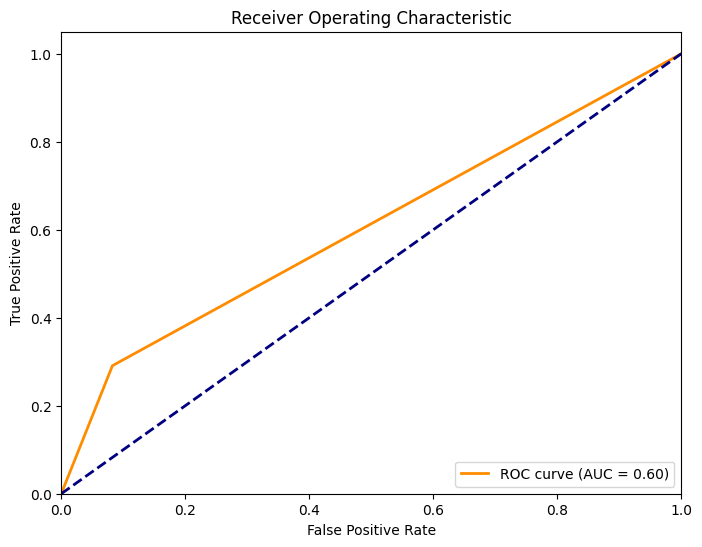

In [353]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

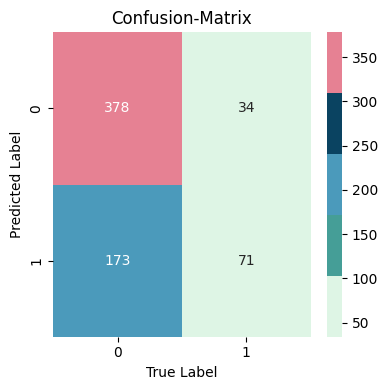

In [354]:
fig,ax = plt.subplots(figsize=(4,4))
ax= sns.heatmap(confusion_matrix(y_test, y_preds),
                annot = True,
                cbar= True,
                fmt='g',
               cmap= theme)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion-Matrix')
plt.tight_layout()
plt.show()

In [355]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.69      0.92      0.79       412
         1.0       0.68      0.29      0.41       244

    accuracy                           0.68       656
   macro avg       0.68      0.60      0.60       656
weighted avg       0.68      0.68      0.64       656

